In [1]:
using Pkg
# Pkg.add("StatProfilerHTML")
# using Cthulhu
# using Polyester
# using StatProfilerHTML
# Pkg.add("BenchmarkTools")
using CategoricalArrays, DataFrames, GLM, StableRNGs,LinearAlgebra, CSV, Distances, Plots, BenchmarkTools,Polyester #, PyPlot, CairoMakie#, RData
using Base.Threads
println(nthreads())

4


In [2]:
# read in meta data  
project_path = "/Users/cl256/Desktop/PDAC_CosMx/"
data_path = project_path * "data/"
meta = select!(DataFrame(CSV.File(data_path *"meta/cell_meta.csv")), Not(:Column1))
select!(meta, Not(["l11", "l12","l1","krt19","hsat2"]))
first(meta,2)

Row,Slide_name,sample,fov,slide_fov,cell_unique_id,cell_type,x_coord,y_coord,total
,String7,String31,Int64,String15,String15,String31,Float64,Float64,Int64
1,B10,PDAC_B10,1,B10_1,B10_1_1,cancer,-33671.0,-9834.29,410
2,B10,PDAC_B10,1,B10_1,B10_1_10,CAF,-33948.4,-9831.95,58


In [3]:
# read in expression files
expr_D10 = DataFrame(CSV.File(data_path * "old/D10_R5042_S2/D10_R5042_S2_exprMat_file.csv")) 
insertcols!(expr_D10, :Slide_name => "D10")
expr_B10 = DataFrame(CSV.File(data_path * "old/B10_R1171_S2/B10_R1171_S2_exprMat_file.csv")) 
insertcols!(expr_B10, :Slide_name => "B10")
expr_C4 = DataFrame(CSV.File(data_path * "old/C4_R5042_S1/C4_R5042_S1_exprMat_file.csv")) 
insertcols!(expr_C4, :Slide_name => "C4")
expr_tma1 = DataFrame(CSV.File(data_path * "Flat files/Run5573_TMA1/Run5573_TMA1_exprMat_file.csv")) 
insertcols!(expr_tma1, :Slide_name => "TMA1")
expr_tma28 = DataFrame(CSV.File(data_path * "Flat files/Run5573_TMA28/Run5573_TMA28_exprMat_file.csv")) 
insertcols!(expr_tma28, :Slide_name => "TMA28")
expr_tma31 = DataFrame(CSV.File(data_path * "Flat files/Run5573_TMA31/Run5573_TMA31_exprMat_file.csv")) 
insertcols!(expr_tma31, :Slide_name => "TMA31")
expr_tma32 = DataFrame(CSV.File(data_path * "Flat files/Run5584_TMA32/Run5584_TMA32_exprMat_file.csv")) 
insertcols!(expr_tma32, :Slide_name => "TMA32")
# combine transcript files 
expr = DataFrame()
expr = vcat(expr, expr_D10, expr_B10,  expr_C4, expr_tma1, expr_tma28, expr_tma31, expr_tma32, cols=:union)
expr[!, "cell_unique_id"] = string.(expr[!, "Slide_name"], "_", expr[!, "fov"], "_", expr[!, "cell_ID"])
# drop some columns
select!(expr, Not(["Slide_name", "fov","cell_ID"]))
# clear memory
expr_D10 = 0
expr_B10 = 0
expr_C4 = 0
expr_tma1 = 0
expr_tma28 = 0
expr_tma31 = 0
expr_tma32 = 0

0

In [4]:
# combine meta and expr
meta_expr = innerjoin(meta, expr, on = :cell_unique_id)
first(meta_expr)

Row,Slide_name,sample,fov,slide_fov,cell_unique_id,cell_type,x_coord,y_coord,total,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,ACVR1,ACVR1B,ACVR2A,ACVRL1,ADGRA2,ADGRA3,ADGRB2,ADGRB3,ADGRD1,ADGRE1,ADGRE2,ADGRE5,ADGRF1,ADGRF3,ADGRF4,ADGRF5,ADGRG1,ADGRG2,ADGRG3,ADGRG5,ADGRG6,ADGRL1,ADGRL2,ADGRL4,ADGRV1,ADIPOQ,ADIRF,ADM2,ADORA2A,AGR2,AHI1,AHR,AKT1,ALCAM,ANGPT1,ANGPT2,ANGPT4,ANGPTL1,ANXA1,ANXA2,ANXA4,APOA1,APOB,APOD,APP,AQP3,AR,AREG,ARF1,ARG1,ARHGDIB,ARTN,ATF3,ATG10,ATG12,ATG5,ATM,ATR,AXL,AZGP1,AZU1,B2M,B3GNT7,BAG3,BATF3,BAX,BCL2,BCL2L1,BECN1,BEST1,BGN,BID,BIRC5,BMP1,BMP2,BMP3,BMP4,BMP5,BMP6,BMP7,BMPR1A,⋯
,String7,String31,Int64,String15,String15,String31,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,⋯
1,D10,PDAC_D10,1,D10_1,D10_1_1,cancer,-26922.5,-20822.4,232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,13,0,1,0,1,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯


In [5]:
# count cells per slide
combine(groupby(meta_expr, [:Slide_name]), nrow => :count)
combine(groupby(meta_expr, [:slide_fov]), nrow => :count)

Row,slide_fov,count
,String15,Int64
1,B10_1,3810
2,B10_3,5230
3,C4_15,2851
4,C4_16,2011
5,C4_17,3526
6,C4_18,3577
7,C4_19,3912
8,C4_20,3302
9,C4_21,3023


In [6]:
radii = [10:10:30;]

# for each fov 
# one test fov to start
test_sample = subset(meta_expr, :slide_fov => ByRow(==("TMA28_9")); skipmissing=true)
display(first(test_sample,2))
    # get all cancer cells, all CAF cells, all ECs, and all macrophages
    canc = subset(test_sample, :cell_type => ByRow(==("cancer")))
    cafs = subset(test_sample, :cell_type => ByRow(==("CAF")))
    # display(size(canc) + size(cafs))
    println("cancer cells:", size(canc))
    # display(first(canc,2))
    println("caf cells:", size(cafs))
    # for each of the receptor cell types (cafs for now)
    # calculate pairwise distances between each cancer cell and each receptor type
    # dm_cafs = DataFrame(LinearAlgebra.Matrix([
    println("distance matrix:")
    dm_cafs = LinearAlgebra.Matrix([
        euclidean(cafs[i,["x_coord","y_coord"]],canc[j,["x_coord","y_coord"]])
        for i in 1:size(cafs)[1], j in 1:size(canc)[1]
    ])
    # , :auto)    
    # for each receptor cell, find cancer cells in different radii away
    # for (r in 1:length(radii)) {
    #     cancer_cells_within_radius = dm_cafs < r
    # }

Row,Slide_name,sample,fov,slide_fov,cell_unique_id,cell_type,x_coord,y_coord,total,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,ACVR1,ACVR1B,ACVR2A,ACVRL1,ADGRA2,ADGRA3,ADGRB2,ADGRB3,ADGRD1,ADGRE1,ADGRE2,ADGRE5,ADGRF1,ADGRF3,ADGRF4,ADGRF5,ADGRG1,ADGRG2,ADGRG3,ADGRG5,ADGRG6,ADGRL1,ADGRL2,ADGRL4,ADGRV1,ADIPOQ,ADIRF,ADM2,ADORA2A,AGR2,AHI1,AHR,AKT1,ALCAM,ANGPT1,ANGPT2,ANGPT4,ANGPTL1,ANXA1,ANXA2,ANXA4,APOA1,APOB,APOD,APP,AQP3,AR,AREG,ARF1,ARG1,ARHGDIB,ARTN,ATF3,ATG10,ATG12,ATG5,ATM,ATR,AXL,AZGP1,AZU1,B2M,B3GNT7,BAG3,BATF3,BAX,BCL2,BCL2L1,BECN1,BEST1,BGN,BID,BIRC5,BMP1,BMP2,BMP3,BMP4,BMP5,BMP6,BMP7,BMPR1A,⋯
,String7,String31,Int64,String15,String15,String31,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,⋯
1,TMA28,PDAC_TMA28_fov9.10,9,TMA28_9,TMA28_9_1,cancer,18302.0,1667.84,349,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,1,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
2,TMA28,PDAC_TMA28_fov9.10,9,TMA28_9,TMA28_9_2,cancer,18299.0,1666.58,224,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯


cancer cells:(1316, 994)
caf cells:(690, 994)
distance matrix:


690×1316 Matrix{Float64}:
 762.084  758.936   103.542  278.314  …  578.869   586.56    591.83
 162.697  163.182   771.447  586.745     877.747   879.077   871.609
 159.598  159.486   746.108  562.338     849.421   850.821   843.435
 176.36   174.142   638.002  458.053     747.509   749.447   742.715
 590.114  586.84    346.726  301.431     355.474   360.847   359.6
 319.692  319.521   838.105  665.016  …  820.521   820.439   811.509
 399.8    399.885   913.945  744.277     849.813   848.977   839.38
 399.359  399.153   889.067  722.118     814.707   813.858   804.252
 404.66   404.468   893.925  727.239     816.435   815.535   805.888
 682.746  679.539   428.969  411.575     241.882   247.153   245.836
   ⋮                                  ⋱                        ⋮
 624.176  623.342   980.493  841.488     731.391   728.272   717.189
 831.179  828.206   635.593  624.495      96.6627   94.1613   83.6634
 642.739  642.33   1048.71   902.5       816.329   813.181   802.082
 878.994  875.9

In [8]:
r = 2
cancer_cells_within_radius = dm_cafs .<= radii[r]
n_cafs = nrow(DataFrame(dm_cafs, :auto))
canc_indices = Any[]
canc_cts = Int16[]
i = 0
for row in eachrow(dm_cafs)
    i = i+1
    if r == 1
        canc_index = findall(.<=(radii[r]), row)
        push!(canc_indices, canc_index)
    else
    # find all cancer cells in that radius distance ring
        canc_index = findall((row.<=(radii[r])) .&  (row.>(radii[r-1])))
        push!(canc_indices, canc_index)
    end 
    # get number of cancer cells
    canc_ct = length(canc_indices[i])
    push!(canc_cts, canc_ct)
end 

# naive implementation 
function naive_lm(n_cafs,cafs,canc_cts,n_expr,num_genes)
    # lm_res = DataFrame(gene = Symbol[], beta = Float16[])
    gene = Vector{Symbol}(undef, num_genes)
    beta = Vector{Float16}(undef, num_genes)
    for i in 1:num_genes # for every gene
        caf_gene_exp_all = Vector{Int16}(undef,n_cafs)
        for caf_index in 1:n_cafs # for every CAF
            # get gene expression in that CAF 
            caf_gene_exp = cafs[caf_index,n_expr[i]]
            # push!(caf_gene_exp_all, caf_gene_exp)
            caf_gene_exp_all[caf_index] = caf_gene_exp
        end 
        # display(caf_gene_exp_all)
        df = DataFrame(x = canc_cts, y = caf_gene_exp_all)
        model = lm(@formula(y ~ x), df)
        gene[i] = n_expr[i]
        beta[i] = coef(model)[2]
        # push!(lm_res, [gene, coef(model)[2]])
    end 
    lm_res=DataFrame(;gene,beta)
end 

function naive_lm_thread(n_cafs,cafs,canc_cts,n_expr,num_genes)
    gene = Vector{Symbol}(undef, num_genes)
    beta = Vector{Float16}(undef, num_genes)
    # Threads.@threads for gene in names(expr)[1:985] # for every gene
    # Threads.@threads for i in 1:num_genes # for every gene
    @batch per=thread for i in 1:num_genes # for every gene
            # caf_gene_exp_all = Int16[]
        caf_gene_exp_all = Vector{Int16}(undef,n_cafs)
        for caf_index in 1:n_cafs # for every CAF
            caf_gene_exp = cafs[caf_index,n_expr[i]]
            # push!(caf_gene_exp_all, caf_gene_exp)
            caf_gene_exp_all[caf_index] = caf_gene_exp
        end 
        df = DataFrame(x = canc_cts, y = caf_gene_exp_all)
        model = lm(@formula(y ~ x), df)
        gene[i] = n_expr[i]
        beta[i] = coef(model)[2]
        # push!(lm_res, [names(expr)[i], coef(model)[2]])
        # push!(lm_res, [gene, coef(model)[2],stderror(model)[2]])
    end 
    lm_res=DataFrame(;gene,beta)
end 

# calculate beta by re-implementation
function beta_manual(n_cafs,cafs,canc_cts,n_expr,num_genes)
    gene = Vector{Symbol}(undef, num_genes)
    beta = Vector{Float16}(undef, num_genes)
    # for gene in names(expr)[1:985] # for every gene
    for i in 1:num_genes # for every gene
        x_mean = mean(canc_cts)
        top_x = canc_cts .- x_mean
        bottom = sum((canc_cts .- x_mean).^2)
        caf_gene_exp_all = Vector{Int16}(undef,n_cafs)
        for caf_index in 1:n_cafs # for every CAF
            # get gene expression in that CAF 
            caf_gene_exp = cafs[caf_index,n_expr[i]]
            # push!(caf_gene_exp_all, caf_gene_exp)
            caf_gene_exp_all[caf_index] = caf_gene_exp
        end 
        y = caf_gene_exp_all
        y_mean = mean(y)
        top_y = y .- y_mean
        top = sum(transpose(top_x) * top_y)
        # beta = top/bottom
        # push!(lm_res, [gene, beta])
        gene[i] = n_expr[i]
        beta[i] = top/bottom
    end 
    lm_res=DataFrame(;gene,beta)
end 

# with threading
function beta_manual_thread(n_cafs,cafs,canc_cts,n_expr,num_genes)
    gene = Vector{Symbol}(undef, num_genes)
    beta = Vector{Float16}(undef, num_genes)
    @batch per=thread for i in 1:num_genes # for every gene
        x_mean = mean(canc_cts)
        top_x = canc_cts .- x_mean
        bottom = sum((canc_cts .- x_mean).^2)
        caf_gene_exp_all = Vector{Int16}(undef,n_cafs)
        for caf_index in 1:n_cafs # for every CAF
            caf_gene_exp = cafs[caf_index,n_expr[i]]
            caf_gene_exp_all[caf_index] = caf_gene_exp
        end 
        y = caf_gene_exp_all
        y_mean = mean(y)
        top_y = y .- y_mean
        top = sum(transpose(top_x) * top_y)
        gene[i] = n_expr[i]
        beta[i] = top/bottom
    end 
    lm_res=DataFrame(;gene,beta)
end 

# beta calculation by re-implementation and save x-related terms 
function x_save(n_cafs,cafs,canc_cts,n_expr,num_genes)
    gene = Vector{Symbol}(undef, num_genes)
    beta = Vector{Float16}(undef, num_genes)
    x_mean = mean(canc_cts)
    # println(x_mean)
    top_x = canc_cts .- x_mean
    bottom = sum((canc_cts .- x_mean).^2)
    for i in 1:num_genes # for every gene
        caf_gene_exp_all = Vector{Int16}(undef,n_cafs)
        for caf_index in 1:n_cafs # for every CAF
            # get gene expression in that CAF 
            caf_gene_exp = cafs[caf_index,n_expr[i]]
            # push!(caf_gene_exp_all, caf_gene_exp)
            caf_gene_exp_all[caf_index] = caf_gene_exp
        end 
        y = caf_gene_exp_all
        y_mean = mean(y)
        top_y = y .- y_mean
        top = sum(transpose(top_x) * top_y)
        # beta = top/bottom
        # push!(lm_res, [gene, beta])
        gene[i] = n_expr[i]
        beta[i] = top/bottom
    end 
    lm_res=DataFrame(;gene,beta)
end 

function x_save_thread(n_cafs,cafs,canc_cts,n_expr,num_genes)
    gene = Vector{Symbol}(undef, num_genes)
    beta = Vector{Float16}(undef, num_genes)
    x_mean = mean(canc_cts)
    top_x = canc_cts .- x_mean
    bottom = sum((canc_cts .- x_mean).^2)
    @batch per=thread for i in 1:num_genes # for every gene
        caf_gene_exp_all = Vector{Int16}(undef,n_cafs)
        for caf_index in 1:n_cafs # for every CAF
            caf_gene_exp = cafs[caf_index,n_expr[i]]
            caf_gene_exp_all[caf_index] = caf_gene_exp
        end 
        y = caf_gene_exp_all
        y_mean = mean(y)
        top_y = y .- y_mean
        top = sum(transpose(top_x) * top_y)
        gene[i] = n_expr[i]
        beta[i] = top/bottom
    end 
    lm_res=DataFrame(;gene,beta)
end 

n_expr = Symbol.(names(expr)) # change strings of gene names to Symbol 
num_genes = 100
println("naive_lm")
@btime naive_lm($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
println("number of threads: ",nthreads())
println("naive_lm_thread")
@btime naive_lm_thread($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
println("beta_manual")
@btime beta_manual($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
println("beta_manual_thread")
@btime beta_manual_thread($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
println("x_save")
@btime x_save($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
println("x_save_thread")
@btime x_save_thread($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)


naive_lm


  6.389 ms (124126 allocations: 9.51 MiB)
number of threads: 4
naive_lm_thread


  1.311 ms (56627 allocations: 8.53 MiB)
beta_manual


  4.581 ms (105226 allocations: 3.37 MiB)
beta_manual_thread


  715.333 μs (36227 allocations: 2.32 MiB)
x_save


  4.375 ms (105028 allocations: 2.30 MiB)
x_save_thread


  741.458 μs (36329 allocations: 1.26 MiB)


Row,gene,beta
,Symbol,Float16
1,AATK,0.006264
2,ABL1,-0.002617
3,ABL2,0.00708
4,ACE,0.0006557
5,ACE2,-0.0106
6,ACKR1,0.003357
7,ACKR3,0.0001644
8,ACKR4,-0.000818
9,ACTA2,0.02972


In [9]:
# @profilehtml naive_lm_thread(canc_cts,num_genes,expr)


In [10]:
r = 2
cancer_cells_within_radius = dm_cafs .<= radii[r]
n_cafs = nrow(DataFrame(dm_cafs, :auto))
canc_indices = Any[]
canc_cts = Int16[]
i = 0
for row in eachrow(dm_cafs)
    i = i+1
    if r == 1
        canc_index = findall(.<=(radii[r]), row)
        push!(canc_indices, canc_index)
    else
    # find all cancer cells in that radius distance ring
        canc_index = findall((row.<=(radii[r])) .&  (row.>(radii[r-1])))
        push!(canc_indices, canc_index)
    end 
    # get number of cancer cells
    canc_ct = length(canc_indices[i])
    push!(canc_cts, canc_ct)
end 

# naive implementation 
function naive_lm(n_cafs,cafs,canc_cts,n_expr,num_genes)
    # lm_res = DataFrame(gene = Symbol[], beta = Float16[])
    gene = Vector{Symbol}(undef, num_genes)
    beta = Vector{Float16}(undef, num_genes)
    for i in 1:num_genes # for every gene
        caf_gene_exp_all = Vector{Int16}(undef,n_cafs)
        for caf_index in 1:n_cafs # for every CAF
            # get gene expression in that CAF 
            caf_gene_exp = cafs[caf_index,n_expr[i]]
            # push!(caf_gene_exp_all, caf_gene_exp)
            caf_gene_exp_all[caf_index] = caf_gene_exp
        end 
        # display(caf_gene_exp_all)
        df = DataFrame(x = canc_cts, y = caf_gene_exp_all)
        model = lm(@formula(y ~ x), df)
        gene[i] = n_expr[i]
        beta[i] = coef(model)[2]
        # push!(lm_res, [gene, coef(model)[2]])
    end 
    lm_res=DataFrame(;gene,beta)
    return Nothing
end 

function naive_lm_thread(n_cafs,cafs,canc_cts,n_expr,num_genes)
    gene = Vector{Symbol}(undef, num_genes)
    beta = Vector{Float16}(undef, num_genes)
    # Threads.@threads for gene in names(expr)[1:985] # for every gene
    # Threads.@threads for i in 1:num_genes # for every gene
    @batch per=thread for i in 1:num_genes # for every gene
            # caf_gene_exp_all = Int16[]
        caf_gene_exp_all = Vector{Int16}(undef,n_cafs)
        for caf_index in 1:n_cafs # for every CAF
            caf_gene_exp = cafs[caf_index,n_expr[i]]
            # push!(caf_gene_exp_all, caf_gene_exp)
            caf_gene_exp_all[caf_index] = caf_gene_exp
        end 
        df = DataFrame(x = canc_cts, y = caf_gene_exp_all)
        model = lm(@formula(y ~ x), df)
        gene[i] = n_expr[i]
        beta[i] = coef(model)[2]
        # push!(lm_res, [names(expr)[i], coef(model)[2]])
        # push!(lm_res, [gene, coef(model)[2],stderror(model)[2]])
    end 
    lm_res=DataFrame(;gene,beta)
end 

# calculate beta by re-implementation
function beta_manual(n_cafs,cafs,canc_cts,n_expr,num_genes)
    gene = Vector{Symbol}(undef, num_genes)
    beta = Vector{Float16}(undef, num_genes)
    # for gene in names(expr)[1:985] # for every gene
    for i in 1:num_genes # for every gene
        x_mean = mean(canc_cts)
        top_x = canc_cts .- x_mean
        bottom = sum((canc_cts .- x_mean).^2)
        caf_gene_exp_all = Vector{Int16}(undef,n_cafs)
        for caf_index in 1:n_cafs # for every CAF
            # get gene expression in that CAF 
            caf_gene_exp = cafs[caf_index,n_expr[i]]
            # push!(caf_gene_exp_all, caf_gene_exp)
            caf_gene_exp_all[caf_index] = caf_gene_exp
        end 
        y = caf_gene_exp_all
        y_mean = mean(y)
        top_y = y .- y_mean
        top = sum(transpose(top_x) * top_y)
        # beta = top/bottom
        # push!(lm_res, [gene, beta])
        gene[i] = n_expr[i]
        beta[i] = top/bottom
    end 
    lm_res=DataFrame(;gene,beta)
end 

# with threading
function beta_manual_thread(n_cafs,cafs,canc_cts,n_expr,num_genes)
    gene = Vector{Symbol}(undef, num_genes)
    beta = Vector{Float16}(undef, num_genes)
    @batch per=thread for i in 1:num_genes # for every gene
        x_mean = mean(canc_cts)
        top_x = canc_cts .- x_mean
        bottom = sum((canc_cts .- x_mean).^2)
        caf_gene_exp_all = Vector{Int16}(undef,n_cafs)
        for caf_index in 1:n_cafs # for every CAF
            caf_gene_exp = cafs[caf_index,n_expr[i]]
            caf_gene_exp_all[caf_index] = caf_gene_exp
        end 
        y = caf_gene_exp_all
        y_mean = mean(y)
        top_y = y .- y_mean
        top = sum(transpose(top_x) * top_y)
        gene[i] = n_expr[i]
        beta[i] = top/bottom
    end 
    lm_res=DataFrame(;gene,beta)
end 

# beta calculation by re-implementation and save x-related terms 
function x_save(n_cafs,cafs,canc_cts,n_expr,num_genes)
    gene = Vector{Symbol}(undef, num_genes)
    beta = Vector{Float16}(undef, num_genes)
    x_mean = mean(canc_cts)
    # println(x_mean)
    top_x = canc_cts .- x_mean
    bottom = sum((canc_cts .- x_mean).^2)
    for i in 1:num_genes # for every gene
        caf_gene_exp_all = Vector{Int16}(undef,n_cafs)
        for caf_index in 1:n_cafs # for every CAF
            # get gene expression in that CAF 
            caf_gene_exp = cafs[caf_index,n_expr[i]]
            # push!(caf_gene_exp_all, caf_gene_exp)
            caf_gene_exp_all[caf_index] = caf_gene_exp
        end 
        y = caf_gene_exp_all
        y_mean = mean(y)
        top_y = y .- y_mean
        top = sum(transpose(top_x) * top_y)
        # beta = top/bottom
        # push!(lm_res, [gene, beta])
        gene[i] = n_expr[i]
        beta[i] = top/bottom
    end 
    lm_res=DataFrame(;gene,beta)
end 

function x_save_thread(n_cafs,cafs,canc_cts,n_expr,num_genes)
    gene = Vector{Symbol}(undef, num_genes)
    beta = Vector{Float16}(undef, num_genes)
    x_mean = mean(canc_cts)
    top_x = canc_cts .- x_mean
    bottom = sum((canc_cts .- x_mean).^2)
    @batch per=thread for i in 1:num_genes # for every gene
        caf_gene_exp_all = Vector{Int16}(undef,n_cafs)
        for caf_index in 1:n_cafs # for every CAF
            caf_gene_exp = cafs[caf_index,n_expr[i]]
            caf_gene_exp_all[caf_index] = caf_gene_exp
        end 
        y = caf_gene_exp_all
        y_mean = mean(y)
        top_y = y .- y_mean
        top = sum(transpose(top_x) * top_y)
        gene[i] = n_expr[i]
        beta[i] = top/bottom
    end 
    lm_res=DataFrame(;gene,beta)
end 

n_expr = Symbol.(names(expr)) # change strings of gene names to Symbol 
num_genes = 985
println("naive_lm")
@btime naive_lm($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
println("number of threads: ",nthreads())
println("naive_lm_thread")
@btime naive_lm_thread($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
println("beta_manual")
@btime beta_manual($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
println("beta_manual_thread")
@btime beta_manual_thread($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
println("x_save")
flush(stdout)
@btime x_save($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
println("x_save_thread")
@btime x_save_thread($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)


naive_lm


  65.115 ms (1222887 allocations: 93.65 MiB)
number of threads: 4
naive_lm_thread


  12.332 ms (557539 allocations: 84.02 MiB)
beta_manual


  44.247 ms (1036248 allocations: 33.22 MiB)
beta_manual_thread


  6.659 ms (356599 allocations: 22.85 MiB)
x_save


  44.102 ms (1034280 allocations: 22.53 MiB)
x_save_thread


  7.468 ms (357586 allocations: 12.27 MiB)


Row,gene,beta
,Symbol,Float16
1,AATK,0.006264
2,ABL1,-0.002617
3,ABL2,0.00708
4,ACE,0.0006557
5,ACE2,-0.0106
6,ACKR1,0.003357
7,ACKR3,0.0001644
8,ACKR4,-0.000818
9,ACTA2,0.02972


In [16]:
test_slide = subset(meta_expr, :Slide_name => ByRow(==("TMA28")); skipmissing=true)
n_expr = Symbol.(names(expr)) # change strings of gene names to Symbol 
num_genes = 100

# for each fov
time_per_fov = DataFrame(fov = Int16[], n_caf = Int16[], naive_lm = Float16[], naive_lm_thread = Float16[], beta_manual = Float16[], beta_manual_thread = Float16[], x_save = Float16[], x_save_thread = Float16[])
# print(time_per_fov)
for FOV_here in unique(test_slide[:,"fov"])[1:10]
    println(FOV_here)
    fov_expr = subset(test_slide, :fov => ByRow(==(FOV_here)))
    # get all cancer cells and all CAF cells
    canc = subset(fov_expr, :cell_type => ByRow(==("cancer")))
    cafs = subset(fov_expr, :cell_type => ByRow(==("CAF")))
    if nrow(canc) < 100 || nrow(cafs) < 100
        println("too few cells")
    else
        n_cafs = nrow(cafs)
        dm_cafs = LinearAlgebra.Matrix([
            euclidean(cafs[i,["x_coord","y_coord"]],canc[j,["x_coord","y_coord"]])
            for i in 1:size(cafs)[1], j in 1:size(canc)[1]
        ])
        r = 2
        cancer_cells_within_radius = dm_cafs .<= radii[r]
        canc_indices = Any[]
        canc_cts = Int16[]
        i = 0
        for row in eachrow(dm_cafs)
            i = i+1
            if r == 1
                canc_index = findall(.<=(radii[r]), row)
                push!(canc_indices, canc_index)
            else
            # find all cancer cells in that radius distance ring
                canc_index = findall((row.<=(radii[r])) .&  (row.>(radii[r-1])))
                push!(canc_indices, canc_index)
            end 
            # get number of cancer cells
            canc_ct = length(canc_indices[i])
            push!(canc_cts, canc_ct)
        end 
        naive_lm_time = @belapsed naive_lm($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
        naive_lm_thread_time = @belapsed naive_lm_thread($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
        beta_manual_time = @belapsed beta_manual($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
        beta_manual_thread_time = @belapsed beta_manual_thread($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
        x_save_time = @belapsed x_save($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
        x_save_thread_time = @belapsed x_save_thread($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)

        push!(time_per_fov, [Int(FOV_here), nrow(cafs), naive_lm_time, naive_lm_thread_time, beta_manual_time, beta_manual_thread_time, x_save_time, x_save_thread_time]) 
    end 
end 
print(time_per_fov)

2


3
too few cells
4
too few cells
5
too few cells
6


7


8


9


10


11


7×8 DataFrame
 Row │ fov    n_caf  naive_lm  naive_lm_thread  beta_manual  beta_manual_thread  x_save    x_save_thread 
     │ Int16  Int16  Float16   Float16          Float16      Float16             Float16   Float16       
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     2    608  0.005665        0.001137      0.003815           0.000576   0.003742      0.0006056
   2 │     6    436  0.004227        0.000914      0.00246            0.000402   0.002419      0.0004187
   3 │     7    790  0.007103        0.001378      0.005184           0.00079    0.005077      0.0008216
   4 │     8    539  0.00522         0.001042      0.00337            0.000498   0.00332       0.000521
   5 │     9    690  0.006355        0.001244      0.004475           0.0006733  0.004383      0.0007076
   6 │    10    642  0.006004        0.001183      0.004105           0.000617   0.004044      0.0006466
   7 │    11    735  0.006702        0.

Row,fov,n_caf,naive_lm,naive_lm_thread,beta_manual,beta_manual_thread,x_save,x_save_thread
,Int16,Int16,Float16,Float16,Float16,Float16,Float16,Float16
1,2,608,0.005833,0.001128,0.003807,0.000571,0.003902,0.000627
2,6,436,0.004265,0.0009055,0.00246,0.0003977,0.002405,0.0004342
3,7,790,0.00717,0.001367,0.00517,0.0007915,0.00508,0.0008554
4,8,539,0.005245,0.001035,0.0034,0.000491,0.003292,0.0005207
5,9,690,0.00643,0.001238,0.00444,0.0006685,0.004383,0.000712
6,10,642,0.0061,0.001174,0.00411,0.00061,0.004078,0.000646
7,11,735,0.006744,0.001284,0.004787,0.00072,0.004677,0.0007625


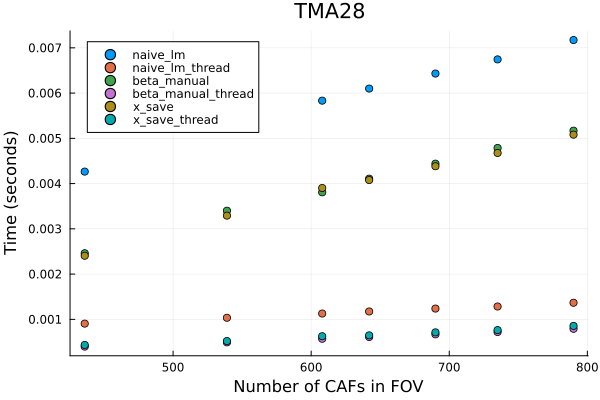

In [13]:
# manually enter results from r
# time_per_fov[!,:r_lm] = [0.236186981201172,0.231831073760986,0.237574815750122,0.255863904953003,0.271380186080933, #2,6,7,8,9
                        # 0.356481075286865,0.241353034973145,0.232091903686523,0.2480309009552,0.244919061660767, #10,11,12,13,14
                        # 0.363600969314575, 0.237097024917603, 0.224981069564819,0.237607955932617,0.358481884002686, #15,18,19,20,21 
                        # 0.251603126525879, 0.221576929092407, 0.221559047698975# 22,24,25
                        # ]
display(time_per_fov)

# plot(time_per_fov[!,"n_caf"], [time_per_fov[!,"r_lm"] time_per_fov[!,"naive_lm"] time_per_fov[!,"beta_manual"] time_per_fov[!,"x_save"]], title="TMA28", seriestype=:scatter,label=["r_lm" "naive_lm" "beta_manual" "x_save"],xaxis = ("Number of CAFs in FOV"),yaxis=("Time (seconds)"))
plot(time_per_fov[!,"n_caf"], [time_per_fov[!,"naive_lm"] time_per_fov[!,"naive_lm_thread"] time_per_fov[!,"beta_manual"] time_per_fov[!,"beta_manual_thread"] time_per_fov[!,"x_save"] time_per_fov[!,"x_save_thread"]], title="TMA28", seriestype=:scatter,label=["naive_lm" "naive_lm_thread" "beta_manual" "beta_manual_thread" "x_save" "x_save_thread"],xaxis = ("Number of CAFs in FOV"),yaxis=("Time (seconds)"))
#


In [14]:
test_slide = subset(meta_expr, :Slide_name => ByRow(==("TMA28")); skipmissing=true)
n_expr = Symbol.(names(expr)) # change strings of gene names to Symbol 
num_genes = 985

# for each fov
time_per_fov = DataFrame(fov = Int16[], n_caf = Int16[], naive_lm = Float16[], naive_lm_thread = Float16[], beta_manual = Float16[], beta_manual_thread = Float16[], x_save = Float16[], x_save_thread = Float16[])
# print(time_per_fov)
for FOV_here in unique(test_slide[:,"fov"])[1:10]
    println(FOV_here)
    fov_expr = subset(test_slide, :fov => ByRow(==(FOV_here)))
    # get all cancer cells and all CAF cells
    canc = subset(fov_expr, :cell_type => ByRow(==("cancer")))
    cafs = subset(fov_expr, :cell_type => ByRow(==("CAF")))
    if nrow(canc) < 100 || nrow(cafs) < 100
        println("too few cells")
    else
        n_cafs = nrow(cafs)
        dm_cafs = LinearAlgebra.Matrix([
            euclidean(cafs[i,["x_coord","y_coord"]],canc[j,["x_coord","y_coord"]])
            for i in 1:size(cafs)[1], j in 1:size(canc)[1]
        ])
        r = 2
        cancer_cells_within_radius = dm_cafs .<= radii[r]
        canc_indices = Any[]
        canc_cts = Int16[]
        i = 0
        for row in eachrow(dm_cafs)
            i = i+1
            if r == 1
                canc_index = findall(.<=(radii[r]), row)
                push!(canc_indices, canc_index)
            else
            # find all cancer cells in that radius distance ring
                canc_index = findall((row.<=(radii[r])) .&  (row.>(radii[r-1])))
                push!(canc_indices, canc_index)
            end 
            # get number of cancer cells
            canc_ct = length(canc_indices[i])
            push!(canc_cts, canc_ct)
        end 
        naive_lm_time = @belapsed naive_lm($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
        naive_lm_thread_time = @belapsed naive_lm_thread($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
        beta_manual_time = @belapsed beta_manual($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
        beta_manual_thread_time = @belapsed beta_manual_thread($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
        x_save_time = @belapsed x_save($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)
        x_save_thread_time = @belapsed x_save_thread($n_cafs,$cafs,$canc_cts,$n_expr,$num_genes)

        push!(time_per_fov, [Int(FOV_here), nrow(cafs), naive_lm_time, naive_lm_thread_time, beta_manual_time, beta_manual_thread_time, x_save_time, x_save_thread_time]) 
    end 
end 
print(time_per_fov)

2


3
too few cells
4
too few cells
5
too few cells
6


7


8


9


10


11


7×8 DataFrame
 Row │ fov    n_caf  naive_lm  naive_lm_thread  beta_manual  beta_manual_thread  x_save   x_save_thread 
     │ Int16  Int16  Float16   Float16          Float16      Float16             Float16  Float16       
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     2    608   0.0584           0.01169      0.04102            0.00589   0.03818       0.006023
   2 │     6    436   0.04218          0.00934      0.0261             0.00405   0.0243        0.004158
   3 │     7    790   0.0708           0.01411      0.05444            0.00793   0.0504        0.00821
   4 │     8    539   0.0525           0.0107       0.03546            0.005005  0.0334        0.00519
   5 │     9    690   0.0636           0.01282      0.04654            0.006775  0.0438        0.007042
   6 │    10    642   0.05972          0.01211      0.0428             0.006336  0.0406        0.006435
   7 │    11    735   0.0666           0.0134    

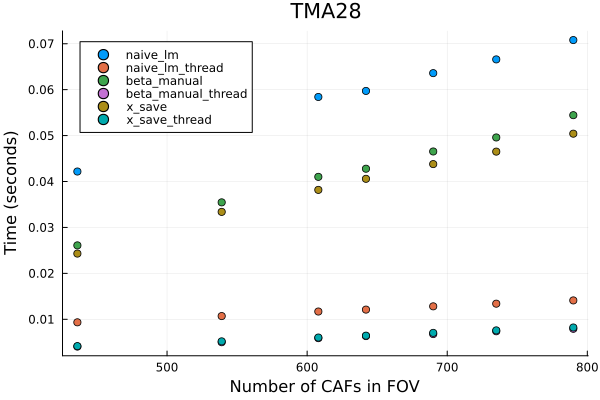

In [15]:
plot(time_per_fov[!,"n_caf"], [time_per_fov[!,"naive_lm"] time_per_fov[!,"naive_lm_thread"] time_per_fov[!,"beta_manual"] time_per_fov[!,"beta_manual_thread"] time_per_fov[!,"x_save"] time_per_fov[!,"x_save_thread"]], title="TMA28", seriestype=:scatter,label=["naive_lm" "naive_lm_thread" "beta_manual" "beta_manual_thread" "x_save" "x_save_thread"],xaxis = ("Number of CAFs in FOV"),yaxis=("Time (seconds)"))
